### Curso: CC521 A Programación Evolutiva 2022-1
Alumno: Jordi Joel Bardales Rojas

## Práctica Calificada 2: Minimización de una función con restricciones


In [270]:
from __future__ import annotations
import math
from math import sin
import numpy as np
from enum import Enum
import random
import matplotlib.pyplot as plt
from typing import Callable
from abc import ABC, abstractmethod
from itertools import combinations


## Descripción del problema
El problema a minimizar esta dado por la siguiente función.

In [250]:
f = lambda x: -5*sin(x[0])*sin(x[1])*sin(x[2])*sin(x[3])*sin(x[4]) - sin(5*x[0])*sin(5*x[1])*sin(x[2])*sin(5*x[3])*sin(5*x[4])
# dominio
domain, n_var = [0, math.pi], 5
# solucion global
x_opt = [round(math.pi/2, 6)]*n_var
print(f"x_opt = {x_opt}, f(x*) = {f([math.pi/2]*n_var)}")


x_opt = [1.570796, 1.570796, 1.570796, 1.570796, 1.570796], f(x*) = -6.0


### 1. Implementación de la representación:
Debido a que en el cruzamiento se están utilizando el valor real $\mathbf{x_i}=(x_{i_1},x_{i_2},x_{i_3},x_{i_4},x_{i_5})$ del cromosoma no hay necesidad de pasar a una representación binaria/gray, además podría causar problemas en el cruce $\mathbf{x_3}=r(\mathbf{x_2}-\mathbf{x_1})+\mathbf{x_2}$ debido al factor $r$ el cual es un número real entre $[0,1]$. Por ese motivo el genotipo es igual al fenotipo.



In [251]:
# Clase individuo
class Individual():
    def __init__(self, phenotype: list[float], domain: tuple[float, float], n_var: int):
        self.domain = domain
        self.n_var = n_var
        self.phenotype = phenotype

    @classmethod
    def newRandom(cls, domain: tuple[float, float], n_var: int):
        phenotype = [random.uniform(domain[0], domain[1]) for _ in range(n_var)]
        return cls(phenotype, domain, n_var)


In [252]:
POPULATION_SIZE = 10

population = [Individual.newRandom(domain, n_var) for _ in range(POPULATION_SIZE)]
print("Representación decimal o real")
for i, ind in enumerate(population):
    print(f"Individuo {i} = {ind.phenotype}")

Representación decimal o real
Individuo 0 = [1.2696485427308943, 2.734723136160673, 2.719652925847388, 2.5519803407782327, 0.7088189951684344]
Individuo 1 = [1.2772917185227615, 1.4041642246833907, 2.2476541789031215, 1.216515722218844, 0.004330674993813726]
Individuo 2 = [0.5966029408188591, 1.1060445551682279, 0.3317128287041281, 0.1182214031871822, 1.4823019503392536]
Individuo 3 = [0.6000441735775928, 2.1018101272716976, 0.9919078000453738, 2.102955783033596, 1.5877183158177193]
Individuo 4 = [0.6477260371100112, 2.522184066578341, 2.826182950546513, 1.6544763893761592, 1.8026230162649837]
Individuo 5 = [0.8033063415320605, 2.993593838526347, 0.45674965762600145, 0.043317138164484195, 2.3799565588679292]
Individuo 6 = [2.4883418946510685, 1.8595435056235143, 0.6777720468574178, 0.5499923923527303, 0.44009460495695585]
Individuo 7 = [0.5415956957328556, 1.2693177466165209, 1.820384353675766, 0.0036579974639260856, 1.8224282536392171]
Individuo 8 = [2.6272009850328617, 2.561081328508

### 2. Implementación del método de cruza

Clase para la selección

In [253]:
class TournamentSelection:
    def __init__(self, nro_individuals: int, tournament_size: int):
        self.nro_individuals = nro_individuals
        self.tournament_size = tournament_size

    def get_individuals(self, population: list[Individual], fitness: list[float]):
        population = list(zip(population, fitness))
        selected: list[Individual] = []
        for _ in range(self.nro_individuals):
            candidates = random.choices(population, k=self.tournament_size)
            selected.append(min(candidates, key=lambda ind: ind[1])[0])
        return selected


#### Movimiento en dirección del mínimo. 
El operador de cruzamiento está diseñado para que se dirija a un mínimo.

Figura[1]: Movimiento del operador de cruzamiento

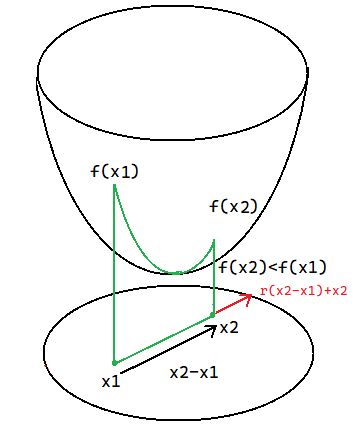

Función que verifica que $\mathbf{x}$ pertenezca a dominio (restricciones)

In [254]:
def check_constraints(x: list[float], domain: list[float]) -> bool:
    for x_gen in x:
        if not domain[0] <= x_gen <= domain[1]:
            return False
    return True

In [255]:
# zi < pi
z = [1.003777, 2.007109, 1.029691, 1.933698, 2.864449]
check_constraints(z, domain)

True

In [256]:
# 4 > pi
z = [1.003777, 2.007109, 4.029691, 1.933698, 2.864449]
check_constraints(z, domain)

False

Clase utilizada para el cruzamiento

In [284]:
class Crossover(ABC):
    @abstractmethod
    def __init__(self, probability: float):
        self.probability = probability

    @abstractmethod
    def make(self, parent1: Individual, parent2: Individual, fitnees: Callable) -> Individual:
        pass

import random
from datetime import datetime
class CustomCrossover(Crossover):
    def __init__(self, probability: float, n_intentos: int):
        super().__init__(probability=probability)
        self.n_intentos = n_intentos

    def make(self, parent1: Individual, parent2: Individual, fitnees: Callable) -> Individual:
        if random.random() < self.probability:
            x1 = np.array(parent1.phenotype)
            x2 = np.array(parent2.phenotype)
            count = 1
            x_fit = [[x1, fitnees(x1)], [x2, fitnees(x2)]]
            # ordenando de acuerdo al fitness f(a) <= f(b) [a, f(a), b, f(b)]
            x1_fit1, x2_fit2 = sorted(x_fit, key=lambda x: x[1])

            x2 = x1_fit1[0]  # menor
            x1 = x2_fit2[0]  # mayor
            # en direccion del menor fitness
            while count < self.n_intentos:
                r = random.random()
                x3 = r * (x2 - x1) + x2
                if check_constraints(x3, parent1.domain):
                    return Individual(x3.tolist(), parent1.domain, parent1.n_var)
                count += 1
            else:
                print(f"Estos padres {x2} y {x1} no pueden generar descendencia")
        return None


##### Esquema general de un AE genérico 

In [379]:
def genenetic_algorithm(max_generation: int,
                        fitness: Callable[[list[float]], float],
                        population: list[Individual],
                        selection: TournamentSelection,
                        crossover: Crossover):
    best: list[Individual] = []
    generation_number = 0
    while generation_number < max_generation:
        generation_number += 1
        # evaluacion de la aptitud de la población inicial (n individuos)
        population_fitness = [fitness(ind.phenotype) for ind in population]
        # seleccion de los padres (para la reproducción)
        parents = selection.get_individuals(population, population_fitness)
        # operadores de variación
        offspring: list[Individual] = []
        # crossover
        for p1, p2 in combinations(parents, 2):
            if p1.phenotype != p2.phenotype:
                child = crossover.make(p1, p2, fitness)
                if child != None:
                    offspring.append(child)
        # evaluacion de la aptitud de los λ descendientes
        offspring_fitness = [fitness(ind.phenotype) for ind in offspring]
        # λ individuos aptos + n padres
        population += offspring
        population_fitness += offspring_fitness
        # seleccionamos un individuo random para la gráfica
        best.append(population[random.randint(0, len(population)-1)])
        # selección del ambiente n
        population = selection.get_individuals(population, population_fitness)
        population_fitness = []
        # impresión de la generación
        if generation_number % int(max_generation/10) == 0:
            print("Generation:", generation_number, "nro descendientes:", len(offspring))
        if len(offspring) == 0:
            break

    plt.plot([fitness(x.phenotype) for x in best], "r-")
    plt.title(f"Generation number {generation_number}")
    plt.show()
    return population


### 3. Grafica del Fitness vs las generaciones (t) 
Se eligirá el mínimo de cada generación para la gráfica.

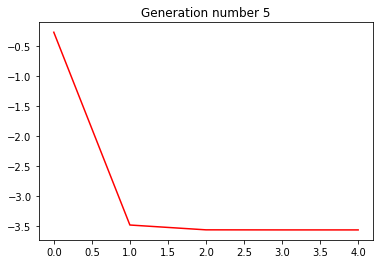

In [380]:
MAX_GENERATION = 100
POPULATION_SIZE = 20
initial_population = [Individual.newRandom(domain, n_var) for _ in range(POPULATION_SIZE)]
best = genenetic_algorithm(max_generation=MAX_GENERATION,
                           fitness=f, 
                           population=initial_population,
                           selection=TournamentSelection(nro_individuals=15, tournament_size=10),
                           crossover=CustomCrossover(probability=0.8, n_intentos=10))


In [357]:
solution = min(best, key=lambda x: f(best[0].phenotype))
print(f"Optimal value\n x* = {solution.phenotype}, f(x*) = {f(solution.phenotype)}")

Optimal value
 x* = [0.9020918596406062, 2.453078159146553, 1.661990942945499, 2.228546160541949, 1.7877821181601241], f(x*) = -1.7847989356975782


### 4. Discusión de resultados
La función de cruzamiento está diseñada para que el descendiente se diriga hacia donde la función disminuye, sin embargo este podría pasarse del dominio de búsqueda, por ello se implementó un cierto número de intentos hasta generar un individuo válido que satisfaga las restricciones.

En la gráfica del número de generaciones vs fitness se observa que no hay una mejora a partir de pocas generaciones (5 aproximadamente), es posible que se haya caido en un mínimo local.

Debido a que el movimiento es operador cruzamiento es en una recta formada por la combinación lineal de los padres, ver figura [1], es posible caer en un mínimo local. Por ello se modificara para agregar un vector aleatorio de perturbación.

### 5. Implementar o mejorar el método de cruza
Se agregó un vector pequeño de perturbacion $\delta$, para evitar caer en mínimos locales.

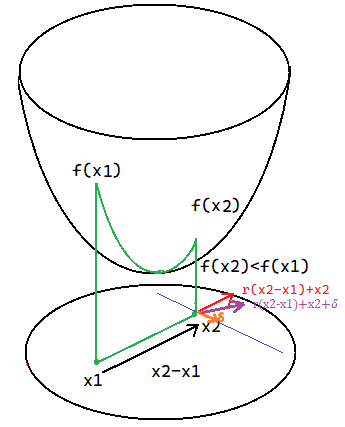

In [349]:
class MyCrossover(Crossover):
    def __init__(self, probability: float, n_intentos: int):
        super().__init__(probability=probability)
        self.n_intentos = n_intentos

    def make(self, parent1: Individual, parent2: Individual, fitnees: Callable):
        if random.random() < self.probability:
            x1 = np.array(parent1.phenotype)
            x2 = np.array(parent2.phenotype)
            count = 1
            x_fit = [[x1, fitnees(x1)], [x2, fitnees(x2)]]
            # ordenando de acuerdo al fitness f(a) <= f(b) [a, f(a), b, f(b)]
            x1_fit1, x2_fit2 = sorted(x_fit, key=lambda x: x[1])

            x2 = x1_fit1[0]  # menor
            x1 = x2_fit2[0]  # mayor
            # en direccion del menor fitness
            while count < self.n_intentos:
                delta = np.random.random(size=parent1.n_var)/8
                r = random.random()
                x3 = r * (x2 - x1) + x2 + delta
                if check_constraints(x3, parent1.domain):
                    return Individual(x3.tolist(), parent1.domain, parent1.n_var)
                count += 1
            else:
                print(f"Estos padres {x2} y {x1} no pueden generar descendencia")
        return None


Estos padres [2.33089779 0.65249156 1.51066292 0.66201061 2.16874954] y [2.53932419 2.57407349 0.6489292  1.45537456 2.27112765] no pueden generar descendencia


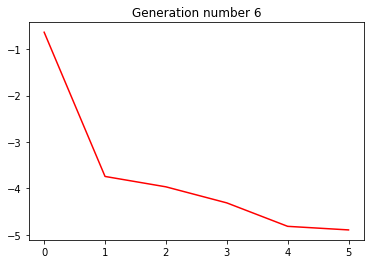

In [387]:
MAX_GENERATION = 100
POPULATION_SIZE = 20 
initial_population = [Individual.newRandom(domain, n_var) for _ in range(POPULATION_SIZE)]
best = genenetic_algorithm(max_generation=100,
                           fitness=f,
                           population=initial_population,
                           selection=TournamentSelection(nro_individuals=15, tournament_size=10),
                           crossover=MyCrossover(probability=0.8, n_intentos=10))


In [388]:
solution = min(best, key=lambda x: f(best[0].phenotype))
print(f"Optimal value\n x* = {solution.phenotype}, f(x*) = {f(solution.phenotype)}")

Optimal value
 x* = [1.5065393378474408, 1.7846000140988958, 1.7418868792919566, 1.6173288768168177, 1.3550999529383654], f(x*) = -4.895293070942839


En la gráfica del número de generaciones vs fitness se observa una mejora en la obtención del mínimo y un un mayor número de padres que no pueden generar descendencia (3 padres). 